#Multi-layer NN for Digit Classification using MNIST

- MNIST
- Dataloader to load dataset
- Apply Transformation
- Implement Multilayer NN with activation functions
- Set up loss and optimizer
- Training Loop (Batch Training)
- Evaluate Model
- GPU Support
- Save & Load Model

#Importing Libraries:

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

#Device Configuration:

In [2]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#if gpu available name it cuda otherwise cpu
print(device)

cpu


#Hyper Parameters:

In [3]:
#hyper parameters
input_size = 784 #because image size is 28 * 28 = 784
hidden_size = 100
num_classes = 10 #digits 0 - 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

#Importing MNIST Dataset:

In [4]:
#MNIST
#training set
train_dataset = torchvision.datasets.MNIST(
    root="/data", #path for storing dataset
    train=True, #implies it is training dataset
    transform=transforms.ToTensor(), #applying transformation
    download=True) #download dataset if it's not available

In [5]:
#testing set
test_dataset = torchvision.datasets.MNIST(
    root="/data", #path for accessing dataset
    train=False, #implies it is testing dataset
    transform=transforms.ToTensor()) #applying transformation
    #dataset already downloaded

In [6]:
#DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

In [7]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape) #batch size is 100, channel is 1, 28 x 28 image size

torch.Size([100, 1, 28, 28]) torch.Size([100])


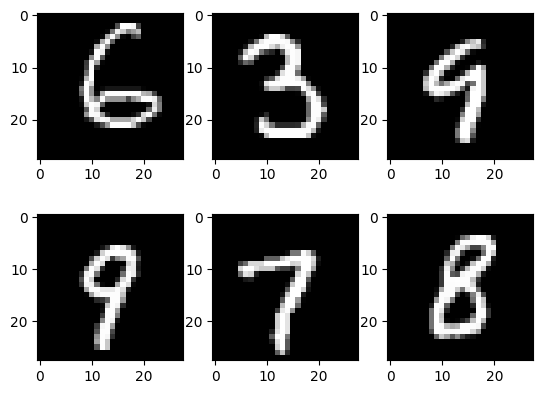

In [8]:
for i in range(6):
  plt.subplot(2,3, i+1) #divides the fig in 2 rows, 3 columns
  #i+1 specifies position of current sub plot
  plt.imshow(samples[i][0], cmap='gray') #cmap = gray, displays image in grayscale
plt.show()

#Neural Network:

In [9]:
class NN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NN, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    #no need to apply softmax
    #we will use cross entropy loss function which automatically applies softmax
    return out

In [10]:
model = NN(input_size, hidden_size, num_classes).to(device)

#Loss & Optimizer:

In [11]:
#Loss & Optimizer:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training Loop:

In [12]:
n_total_steps = len(train_loader) #60000 (total samples) / 100 (batch size) = 600

train_losses = [] #to store losses

for epoch in range(num_epochs): #iterate through epochs
  running_loss = 0.0  # Track loss for the epoch
  for i, (images, labels) in enumerate(train_loader): #iterate through batches
    #shape: [100, 1, 28, 28]
    #input_size = 784
    #image tensor needs [100, 784]

    #reshaping:
    images = images.reshape(-1, 28*28).to(device) #pushes to gpu if available
    labels = labels.to(device)

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #running_loss += loss.item()

    if(i+1) % 100 == 0:
      print(f'epoch: {epoch + 1} / {num_epochs}, step: {i+1} / {n_total_steps}, loss = {loss.item():.4f}')
      train_losses.append(loss.item())

  # Calculate average loss for the epoch
  #avg_loss = running_loss / n_total_steps
  #train_losses.append(avg_loss)  # Store loss

epoch: 1 / 2, step: 100 / 600, loss = 0.4055
epoch: 1 / 2, step: 200 / 600, loss = 0.3328
epoch: 1 / 2, step: 300 / 600, loss = 0.4091
epoch: 1 / 2, step: 400 / 600, loss = 0.2986
epoch: 1 / 2, step: 500 / 600, loss = 0.3890
epoch: 1 / 2, step: 600 / 600, loss = 0.2179
epoch: 2 / 2, step: 100 / 600, loss = 0.3920
epoch: 2 / 2, step: 200 / 600, loss = 0.2411
epoch: 2 / 2, step: 300 / 600, loss = 0.2615
epoch: 2 / 2, step: 400 / 600, loss = 0.1586
epoch: 2 / 2, step: 500 / 600, loss = 0.1156
epoch: 2 / 2, step: 600 / 600, loss = 0.1343


#Evaluate Model:

In [13]:
#test

with torch.no_grad():
  n_correct = 0 #no. of correct predictions
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]

  for images, labels in test_loader:
    images = images.reshape(-1, 28 * 28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    #torch.max returns max value(highest probability) and its index(class label)
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0] #no. of samples in current batch
    n_correct += (predictions == labels).sum().item() #+1 for each correct prediction

    for i in range(labels.size(0)):
      label = labels[i]
      pred = predictions[i]
      if(label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy = {acc}')

  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of Digit {i}: {acc:.4f}%')

accuracy = 95.28
Accuracy of Digit 0: 98.1633%
Accuracy of Digit 1: 98.3260%
Accuracy of Digit 2: 95.8333%
Accuracy of Digit 3: 96.0396%
Accuracy of Digit 4: 94.0937%
Accuracy of Digit 5: 90.2466%
Accuracy of Digit 6: 97.2860%
Accuracy of Digit 7: 94.8444%
Accuracy of Digit 8: 93.4292%
Accuracy of Digit 9: 93.6571%


#Learning Curve:

In [ ]:
batch_numbers = list(range(1, len(train_losses) + 1))  #to create a list of epoch numbers
plt.plot(batch_numbers, train_losses, label='Training Loss')
plt.xlabel('Batch')  #x-axis label
plt.ylabel('Loss')  #y-axis label
plt.title('Learning Curve')  #title of the plot
plt.legend()
plt.show()  #to display the plot

#Evaluation Metrics:

In [25]:
all_labels = []
all_predictions = []
for images, labels in test_loader:
    images = images.reshape(-1, 28 * 28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

target_names = [f"Digit {i}" for i in range(10)]

print(classification_report(all_labels, all_predictions, target_names=target_names))

              precision    recall  f1-score   support

     Digit 0       0.97      0.98      0.98       980
     Digit 1       0.98      0.98      0.98      1135
     Digit 2       0.95      0.96      0.95      1032
     Digit 3       0.92      0.96      0.94      1010
     Digit 4       0.96      0.94      0.95       982
     Digit 5       0.97      0.90      0.94       892
     Digit 6       0.94      0.97      0.96       958
     Digit 7       0.96      0.95      0.95      1028
     Digit 8       0.94      0.93      0.94       974
     Digit 9       0.95      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



#Save & Load Model:

In [17]:
# Save model parameters
torch.save(model.state_dict(), "MNIST_Model_Parameters.pt")

In [18]:
#Load model:
loaded_model = NN(input_size, hidden_size, num_classes)
loaded_model.load_state_dict(torch.load("MNIST_Model_Parameters.pt"))
loaded_model.eval()

<ipython-input-18-a3e2f201ecf5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("MNIST_Model_Parameters.pt"))


NN(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)

In [19]:
# Test the loaded model
with torch.no_grad():
  n_correct = 0 #no. of correct predictions
  n_samples = 0

  for images, labels in test_loader:
    images = images.reshape(-1, 28 * 28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    #torch.max returns max value(highest probability) and its index(class label)
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0] #no. of samples in current batch
    n_correct += (predictions == labels).sum().item() #+1 for each correct prediction

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy = {acc}')

accuracy = 95.28
